In [1]:
%cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters


In [2]:
import bwb
from pathlib import Path

main_path = Path(".")
data_path = main_path / "data"
face_path = data_path / "face_recognized.npy"
face_path

PosixPath('data/face_recognized.npy')

In [3]:
import numpy as np

arr = np.load(face_path)
arr.shape

(148436, 784)

In [4]:

from bwb.distributions.data_loaders import *

In [5]:
faces = DistributionDrawDataLoader(arr, (28, 28))
faces

DistributionDrawDataLoader((n_models, n_supp)=(148436, 784))

In [77]:
indx = 4
faces[indx]

In [78]:
f1, f2 = faces[0].grayscale_weights, faces[indx].grayscale_weights

In [79]:
import torch
from bwb.config import conf
A = torch.stack([f1, f2])

v1 = torch.tensor((1, 0, 0, 0), dtype=conf.dtype, device=conf.device)
v2 = torch.tensor((0, 1, 0, 0), dtype=conf.dtype, device=conf.device)
v3 = torch.tensor((0, 0, 1, 0), dtype=conf.dtype, device=conf.device)
v4 = torch.tensor((0, 0, 0, 1), dtype=conf.dtype, device=conf.device)
A.shape

torch.Size([2, 28, 28])

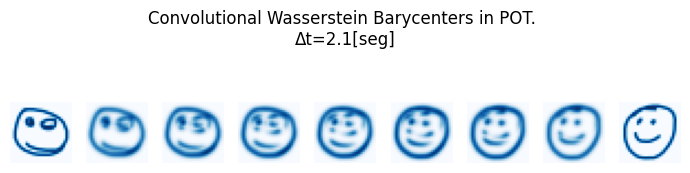

In [80]:
import time

from matplotlib import pyplot as plt
from bwb.config import config
from bwb import bregman
eps = config.eps

nb_images = 9
fig, axes = plt.subplots(1, nb_images, figsize=(7, 2))
cm = 'Blues'
# regularization parameter
reg = 2e-3
entrop_sharp = False
tic_ = time.time()
for i in range(nb_images):
    for j in range(1):
        ax = axes[i]
        tic = time.time()

        tx = float(i) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        weights = (1 - tx) * torch.tensor([1, 0], device=conf.device) + tx * torch.tensor([0, 1], device=conf.device)

        if i == 0 and j == 0:
            ax.imshow(f1.cpu(), cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            ax.imshow(f2.cpu(), cmap=cm)
        else:
            # call to barycenter computation
            bar, log = bregman.convolutional_barycenter2d(
                A, reg, weights,
                # entrop_sharp=entrop_sharp,
                numItermax=1_000, stopThr=1e-8,
                # verbose=True,
                warn=False,
                log=True,
            )
            bar = bar.cpu()
            ax.imshow(bar, cmap=cm)
        ax.axis('off')

        toc = time.time()
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'Convolutional Wasserstein Barycenters in POT. {d_time}')

plt.tight_layout()
# plt.savefig(img_path / f"{additional_info}-entrop-sharp-{entrop_sharp}-conv-wasserstein-bar.png",
#             dpi=400)
plt.show()

In [81]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder

In [82]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [83]:
LATENT_DIM = 64
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

G = Generator(LATENT_DIM, CHANNELS_IMG).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

In [84]:

CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks" 
FACE_PATH = NETS_PATH / f"_resnet_face_zDim{LATENT_DIM}_gauss_bs_128_recognized_augmented_WAE_WGAN_loss_l1_32p32"

FACE_PATH

PosixPath('wgan_gp/networks/_resnet_face_zDim64_gauss_bs_128_recognized_augmented_WAE_WGAN_loss_l1_32p32')

In [85]:
from wgan_gp.wgan_gp_vae.utils import load_checkpoint

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

Encoder(
  (res_layers): Sequential(
    (res1): ResidualBlock(
      (shortcut): Conv2d(1, 128, kernel_size=(1, 1), stride=(1, 1))
      (resample): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (act_func): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (res2): ResidualBlock(
      (resample): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (act_func): LeakyReLU(negative_slope=0.2)
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (res3): ResidualBlock(
      (r

In [86]:
from wgan_gp.wgan_gp_vae.utils import ProjectorOnManifold
import torchvision.transforms as T


proj = ProjectorOnManifold(
    E, G, 
    transform_in=T.Compose(
            [
                # From pdf to grayscale
                T.Lambda(lambda x: x / torch.max(x)),
                # T.Lambda(lambda x: x),
                T.ToPILImage(),
                T.Resize((32, 32)),
                T.ToTensor(),
                T.Normalize(
                    [0.5 for _ in range(1)],
                    [0.5 for _ in range(1)],
                ),
            ]
        ),
    transform_out=T.Compose(
            [
                # Ensure the range is in [0, 1]
                T.Lambda(lambda x: x - torch.min(x)),
                T.Lambda(lambda x: x / torch.max(x)),
                # T.Lambda(lambda x: 1 - x),
                T.ToPILImage(),
                T.Resize((28, 28)),
                T.ToTensor(),
                T.Lambda(lambda x: x / torch.sum(x)),
                T.Lambda(lambda x: x.squeeze(0)),
            ]
        ))

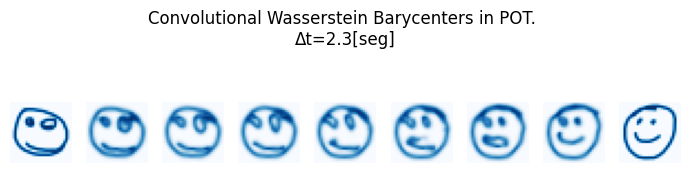

In [87]:
import time

from matplotlib import pyplot as plt
from bwb.config import config
eps = config.eps

# nb_images = 7
fig, axes = plt.subplots(1, nb_images, figsize=(7, 2))
cm = 'Blues'
# regularization parameter
reg = 2e-3
entrop_sharp = False
tic_ = time.time()
for i in range(nb_images):
    for j in range(1):
        ax = axes[i]
        tic = time.time()

        tx = float(i) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        weights = (1 - tx) * torch.tensor([1, 0], device=conf.device) + tx * torch.tensor([0, 1], device=conf.device)

        if i == 0 and j == 0:
            ax.imshow(f1.cpu(), cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            ax.imshow(f2.cpu(), cmap=cm)
        else:
            # call to barycenter computation
            bar, log = bwb.bregman.convolutional_barycenter2d(
                A, reg, weights,
                # entrop_sharp=entrop_sharp,
                numItermax=1_000, stopThr=1e-8,
                # verbose=True,
                warn=False,
                log=True,
            )
            bar = proj(bar).cpu()
            ax.imshow(bar, cmap=cm)
        ax.axis('off')

        toc = time.time()
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'Convolutional Wasserstein Barycenters in POT. {d_time}')

plt.tight_layout()
# plt.savefig(img_path / f"{additional_info}-entrop-sharp-{entrop_sharp}-conv-wasserstein-bar.png",
#             dpi=400)
plt.show()